### **Task 2. Financial Impact of Reducing Prices**

In [148]:
# importing packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from datetime import datetime

sns.set(style="whitegrid")

#### Part 1. Build dataset with number of GeneXpert purchased (TGF)

Cleaning Transaction Summary Dataset:

In [149]:
# importing tgf transaction summary dataset - filtered for 'TB molecular diagnostics'
tgf_trans = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/TGF/transaction_summary.csv', encoding='utf-16', sep='\t')
# dropping first row
tgf_trans = tgf_trans.drop(index=0)

# transforming date columns into datetime format
date_columns = ['Purchase Order Date', 'Scheduled Delivery Date', 'Actual Delivery Date']

for col in date_columns:
    # issue with date columns - 'sept' to 'sep'
    tgf_trans[col] = tgf_trans[col].str.replace('Sept', 'Sep')
    tgf_trans[col] = pd.to_datetime(tgf_trans[col], format='%d-%b-%y')

# transforming columns to numerical
cols_to_num = ['Pack quantity', 'Product pack (USD)', 'Total Product Cost (USD)']

for col in cols_to_num:
    tgf_trans[col] = tgf_trans[col].str.replace(',', '').astype(float)
    tgf_trans[col] = pd.to_numeric(tgf_trans[col], errors='coerce')

# renaming columns
tgf_trans = tgf_trans.rename(columns={"Supplier/Agent/Manufacturer/Intermediatry  ": "Supplier/Agent/Manufacturer/Intermediatry",
                                      "Manufacturer  ": "Manufacturer", 
                                      "Description ": "Description",
                                      "Freight Cost ": "Freight Cost"})

# excluding regional/multicountry observations - e.g. 'Africa', 'Americas', etc.
valid_codes = [country.alpha_3 for country in pycountry.countries]
tgf_trans['Country Code'] = tgf_trans['Grant Name'].str[:3]
tgf_trans = tgf_trans[tgf_trans['Country Code'].isin(valid_codes)]

Retaining GeneXpert and calculating total purchases:

In [ ]:
# keep only Cepheid products
tgf_ceph = tgf_trans[(tgf_trans['Manufacturer']=='Cepheid') & tgf_trans['Description'].str.startswith('Cepheid')]

# creating column for number of tests in each product pack
tgf_ceph['N Units in Pack'] = tgf_ceph['Product Pack'].str.extract('(\d+)').astype(int)

# total number of tests per order
tgf_ceph['N Units Total'] = tgf_ceph['N Units in Pack'] * tgf_ceph['Pack quantity']

In [151]:
tgf_ceph.head()

Country/Teritorry  Grant Name Supplier/Agent/Manufacturer/Intermediatry  \
1       Afghanistan  AFG-T-UNDP                           Direct from Mfg   
2       Afghanistan  AFG-T-UNDP                           Direct from Mfg   
3       Afghanistan  AFG-T-UNDP                           Direct from Mfg   
4       Afghanistan  AFG-T-UNDP                           Direct from Mfg   
5       Afghanistan  AFG-T-UNDP                           Direct from Mfg   

  Manufacturer                    Product Category                   Product  \
1      Cepheid  Diagnostic, PPE and Medical Device  TB molecular diagnostics   
2      Cepheid  Diagnostic, PPE and Medical Device  TB molecular diagnostics   
3      Cepheid  Diagnostic, PPE and Medical Device  TB molecular diagnostics   
4      Cepheid  Diagnostic, PPE and Medical Device  TB molecular diagnostics   
5      Cepheid  Diagnostic, PPE and Medical Device  TB molecular diagnostics   

                                         Description   Product Pack  \
1  Cepheid GeneXpert Model GX-IV- 4 module Instru...  1 unit / test   
2  Cepheid GeneXpert Model GX-IV- 4 module Instru...  1 unit / test   
3   Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]       50 tests   
4   Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]       50 tests   
5   Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]       50 tests   

  Purchase Order Date Scheduled Delivery Date  ... Purchase Order Number  \
1          2015-07-29              2015-10-15  ...      AFG10-GP404135-1   
2          2017-10-05              2017-12-19  ...      AFG10-GP406031-1   
3          2015-07-29              2015-10-15  ...      AFG10-GP404135-1   
4          2015-07-29              2016-03-01  ...            GP404135-1   
5          2017-10-05              2017-12-19  ...      AFG10-GP406031-1   

  Invoice Currency Name Primary Key         Status Pack quantity  \
1  United States Dollar       61987  Admin-Publish           4.0   
2  United States Dollar       73391  Admin-Publish          11.0   
3  United States Dollar       61988  Admin-Publish          24.0   
4  United States Dollar       66556  Admin-Publish          95.0   
5  United States Dollar       73392      Published         110.0   

  Product pack (USD) Total Product Cost (USD) Country Code N Units in Pack  \
1            17500.0                  70000.0          AFG               1   
2            17500.0                 192500.0          AFG               1   
3              499.0                  11976.0          AFG              50   
4              499.0                  47405.0          AFG              50   
5              499.0                  54890.0          AFG              50   

   N Units Total  
1            4.0  
2           11.0  
3         1200.0  
4         4750.0  
5         5500.0  

[5 rows x 25 columns]

In [152]:
tgf_ceph['Description'].value_counts()

Description
Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]                                              460
Cepheid Xpert MTB/RIF Ultra (50s) [GXMTB/RIF-ULTRA-50]                                        338
Cepheid GeneXpert Model GX-IV- 4 module Instrument with laptop [GXIV-4-L]                     100
Cepheid GeneXpert Model GX-IV- 4 module Instrument with desktop [GXIV-4D]                      86
Cepheid Xpert MTB/XDR kit (10s) [GXMTB/XDR-10]                                                 82
Cepheid GeneXpert Model GX-XVI-16 module instrument with desktop[GXXVI-16-D]                   19
Cepheid GeneXpert Model GX-IV R2 2-module (10-color) Instrument with laptop [GXIV-2-L-10C]     13
Cepheid GeneXpert IV system with desktop computer (two sites) [GXIV-2-D]                       11
Cepheid GeneXpert IV system with laptop computer (two sites) [GXIV-2-L]                        11
Cepheid GeneXpert Model GX-XVI-16 module instrument with laptop [GXXVI-16-L]                    7
Cepheid 

In [ ]:
# change product names
prod_dict = {"Cepheid Xpert MTB/XDR kit (10s) [GXMTB/XDR-10]": "Cepheid Xpert MTB/XDR",
   "Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]": "Cepheid Xpert MTB/RIF",
   "Cepheid Xpert MTB/RIF Ultra (50s) [GXMTB/RIF-ULTRA-50]": "Cepheid Xpert MTB/RIF Ultra",
   "Cepheid Xpert MTB/RIF Ultra (10s) [GXMTB/RIF-ULTRA-10]": "Cepheid Xpert MTB/RIF Ultra"}

tgf_ceph['Description'] = tgf_ceph['Description'].map(prod_dict).fillna(tgf_ceph['Description'])

Include fixed prices to account for Xpert price drop:

In [ ]:
date1 = datetime.strptime('06-08-2012', '%d-%m-%Y')
date2 = datetime.strptime('19-09-2023', '%d-%m-%Y')

for index, row in tgf_ceph.iterrows():
    if row['Description'] in ['Cepheid Xpert MTB/RIF', 'Cepheid Xpert MTB/RIF Ultra']:
        if row['Purchase Order Date'] <= date1:
            tgf_ceph.loc[index, 'Unit Price'] = 16.86
        elif row['Purchase Order Date'] <= date2:
            tgf_ceph.loc[index, 'Unit Price'] = 9.98
        else:
            tgf_ceph.loc[index, 'Unit Price'] = 7.97
    elif row['Description'] == 'Cepheid Xpert MTB/XDR':
        if row['Purchase Order Date'] > date2:
            tgf_ceph.loc[index, 'Unit Price'] = 14.9
        else:
            tgf_ceph.loc[index, 'Unit Price'] = 19.8
    else:
        tgf_ceph.loc[index, 'Unit Price'] = row['Total Product Cost (USD)'] / row['N Units Total']

Grouping by country, year and product for final dataset:

In [155]:
tgf_final = tgf_ceph.groupby(['Country/Teritorry', 
                              tgf_ceph['Purchase Order Date'].dt.year, 
                              'Description', 'Unit Price'])['N Units Total'].sum().reset_index()

In [156]:
tgf_final

Country/Teritorry  Purchase Order Date  \
0         Afghanistan                 2015   
1         Afghanistan                 2015   
2         Afghanistan                 2017   
3         Afghanistan                 2017   
4         Afghanistan                 2018   
..                ...                  ...   
713          Zimbabwe                 2020   
714          Zimbabwe                 2021   
715          Zimbabwe                 2022   
716          Zimbabwe                 2023   
717          Zimbabwe                 2024   

                                           Description  Unit Price  \
0    Cepheid GeneXpert Model GX-IV- 4 module Instru...    17500.00   
1                                Cepheid Xpert MTB/RIF        9.98   
2    Cepheid GeneXpert Model GX-IV- 4 module Instru...    17500.00   
3                                Cepheid Xpert MTB/RIF        9.98   
4                                Cepheid Xpert MTB/RIF        9.98   
..                                                 ...         ...   
713                        Cepheid Xpert MTB/RIF Ultra        9.98   
714                        Cepheid Xpert MTB/RIF Ultra        9.98   
715                        Cepheid Xpert MTB/RIF Ultra        9.98   
716                        Cepheid Xpert MTB/RIF Ultra        9.98   
717                        Cepheid Xpert MTB/RIF Ultra        7.97   

     N Units Total  
0              4.0  
1           5950.0  
2             11.0  
3           5500.0  
4          10000.0  
..             ...  
713       229800.0  
714        89400.0  
715       109650.0  
716       136850.0  
717        55000.0  

[718 rows x 5 columns]

Saving final dataset to 'Data' folder:

In [157]:
tgf_final.to_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/tgf_purchases.csv')

#### Part 2. Build dataset with countries' TB funding by source and total requirements (WHO)

In [10]:
# reading in WHOs bduget dataset
fund = pd.read_csv("/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/WHO/TB_budget_2024-12-05.csv")

Selecting necessary variables:
- Expected funding from domestic sources, including loans (US Dollars): `cf_tot_domestic`
- Expected funding from USAID (US Dollars): `cf_tot_usaid`
- Expected funding from the Global Fund to Fight AIDS, Tuberculosis and Malaria (US Dollars): `cf_tot_gf`
- Expected funding from other sources (US Dollars): `cf_tot_grnt`
- Expected funding for laboratory infrastructure, equipment and supplies (US Dollars): `cf_lab`
- Total expected funding from all sources (US Dollars): `cf_tot_sources`
- Budget required for laboratory infrastructure, equipment and supplies (US Dollars): `budget_lab`
- Total budget required (US Dollars): `budget_tot`

In [11]:
fund_vars = ['country', 'year', 'cf_tot_domestic', 'cf_tot_usaid', 'cf_tot_gf', 'cf_lab', 'cf_tot_grnt', 
             'cf_tot_sources', 'budget_lab', 'budget_tot']

fund = fund[fund_vars]

# removing rows without funding data
rows_to_drop = fund[fund[fund.columns[2:]].isna().all(axis=1)]
fund = fund[~fund.index.isin(rows_to_drop.index)]

Creating 'Funding Gap' variable:

In [12]:
fund['budget_gap'] = fund['budget_tot']-fund['cf_tot_sources']

In [13]:
fund

country  year  cf_tot_domestic  cf_tot_usaid   cf_tot_gf     cf_lab  \
0     Afghanistan  2018         533779.0     4462530.0   3178499.0  2473391.0   
1     Afghanistan  2019         511854.0     2766449.0   6533095.0  2208668.0   
2     Afghanistan  2020        1171864.0     3000000.0   6935551.0  3188713.0   
3     Afghanistan  2021              NaN           NaN   7638546.0  1696418.0   
4     Afghanistan  2022         269339.0     1555946.0   6876137.0   715071.0   
...           ...   ...              ...           ...         ...        ...   
1500     Zimbabwe  2020         247705.0     1870556.0   8300758.0  2541507.0   
1501     Zimbabwe  2021        2096683.0     3284585.0   9803368.0  2401506.0   
1502     Zimbabwe  2022        1000000.0     3058830.0   9487457.0  1800050.0   
1503     Zimbabwe  2023        1000000.0     9378910.0   5774773.0  3644102.0   
1504     Zimbabwe  2024        1000000.0     1937554.0  10241036.0  1600057.0   

      cf_tot_grnt  cf_tot_sources  budget_lab  budget_tot  budget_gap  
0       2523675.0      10698483.0   2543262.0  10881354.0    182871.0  
1       3608394.0      13419792.0   2797414.0  16957452.0   3537660.0  
2       6871009.0      17978424.0   3200000.0  19137128.0   1158704.0  
3       2995053.0      10633599.0   1696418.0  10633599.0         0.0  
4       1898528.0      10599950.0    515246.0  14141821.0   3541871.0  
...           ...             ...         ...         ...         ...  
1500     337233.0      10756252.0   3058011.0  31504677.0  20748425.0  
1501     911965.0      16096601.0   6529001.0  32126351.0  16029750.0  
1502    1301355.0      14847642.0   3557975.0  22656137.0   7808495.0  
1503          NaN      16153683.0   4840102.0  17359487.0   1205804.0  
1504          NaN      13178590.0  25072529.0  57500712.0  44322122.0  

[967 rows x 11 columns]

Saving final dataset to 'Data' folder:

In [14]:
fund.to_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/funding_who.csv')

#### Part 3. Calculate Savings from Price Drop

In [169]:
# clean columns
savings = tgf_final.rename(
    columns={'Country/Teritorry': 'Country',
        'Purchase Order Date': 'Year'})

For every year, I will simulate a price drop of Ultra tests to 5$ and of XDR tests to $10. 

Then I will calculate savings by computing: $\text{Qt. Ordered}*∆\text{Price}$

In [171]:
# simulate price drop to $5 for ultra tests
    # 7.97 -> 5
    # 9.98 -> 5
# simulate price drop to $10 for xdr tests

savings['Lower Price'] = savings['Unit Price'].apply(
    lambda x: 5 if x in [9.98, 7.97] else (10 if x in [14.9, 19.8] else x))

# savings per entry
savings['Savings'] = savings['N Units Total']*(savings['Unit Price']-savings['Lower Price'])

Now calculate:
- Total TGF Savings 2023 and 2024 (until May)
- 2023 TGF Savings Breakdown by coutry - in absolute and % of budget gap

In [215]:
print(f"Total TGF Savings 2023: {round(savings[savings['Year']==2023]['Savings'].sum(),0)}$")
print(f"Total TGF Savings 2024 (until May): {round(savings[savings['Year']==2024]['Savings'].sum(),0)}$")

Total TGF Savings 2023: 15553914.0$
Total TGF Savings 2024 (until May): 2176222.0$


In [232]:
# country breakdown
# only 35 countries ordered in 2023
country_break = pd.DataFrame(savings[savings['Year']==2023].groupby("Country", as_index=False)["Savings"].sum())
country_break['Savings'] = country_break['Savings'].round(0)

country_break.head()

Country    Savings
0      Angola   153882.0
1     Armenia    16026.0
2  Azerbaijan   136800.0
3  Bangladesh  1543800.0
4     Belarus   177786.0

In [233]:
# merge with funding dataset for comparisons
country_break = pd.merge(country_break, fund[fund['year']==2023],
    left_on=['Country'],
    right_on=['country'],
    how='left').drop(columns=['country', 'year'])

In [234]:
country_break['Perc. TGF Fund'] = round(country_break['Savings']/country_break['cf_tot_gf'],3)

country_break['Perc. Total Fund'] = round(country_break['Savings']/country_break['budget_tot'],3)

country_break['Perc. Gap'] = country_break.apply(
    lambda row: 'No Gap' if row['budget_gap'] <= 0 else round(row['Savings'] / row['budget_gap'],3),
    axis=1)

country_break['Perc. Diagnosis Gap'] = country_break.apply(
    lambda row: 'No Gap' if (row['budget_lab'] - row['cf_lab']) <= 0 else round(row['Savings'] / (row['budget_lab'] - row['cf_lab']),3),
    axis=1)

In [235]:
# clean
country_break = country_break[['Country', 'Savings', 'Perc. TGF Fund', 'Perc. Total Fund', 'Perc. Gap', 'Perc. Diagnosis Gap']]

In [236]:
country_break

Country    Savings  Perc. TGF Fund  Perc. Total Fund  \
0                     Angola   153882.0           0.054             0.008   
1                    Armenia    16026.0             NaN             0.022   
2                 Azerbaijan   136800.0           0.064             0.008   
3                 Bangladesh  1543800.0           0.027             0.008   
4                    Belarus   177786.0             NaN               NaN   
5                     Bhutan    17000.0           0.026             0.010   
6               Burkina Faso   166867.0           0.045             0.045   
7                   Cambodia   747000.0           0.107             0.021   
8   Central African Republic        0.0           0.000             0.000   
9                      Congo    75717.0           0.066             0.018   
10                      Cuba   222471.0             NaN               NaN   
11                  Djibouti    64218.0             NaN               NaN   
12                   Eritrea   144100.0           0.085             0.038   
13                  Ethiopia  1832982.0           0.091             0.014   
14                    Gambia    66375.0           0.061             0.054   
15                   Georgia   107440.0             NaN               NaN   
16                 Guatemala    16766.0           0.011             0.002   
17             Guinea-Bissau    84162.0           0.051             0.026   
18                Kazakhstan    58800.0           0.014             0.000   
19                     Kenya  2676003.0           0.106             0.040   
20                    Malawi   418650.0           0.063             0.012   
21                   Moldova        0.0             NaN               NaN   
22                  Mongolia    19600.0           0.006             0.001   
23                   Myanmar  1008830.0           0.022             0.010   
24                 Nicaragua    70686.0             NaN               NaN   
25                      Peru    83166.0           0.014             0.001   
26               Philippines   484012.0           0.012             0.001   
27                   Senegal   309756.0           0.206             0.031   
28                   Somalia   317600.0           0.024             0.024   
29               South Sudan   138910.0           0.026             0.026   
30                Tajikistan   157009.0           0.029             0.008   
31                  Thailand  1131883.0           0.184             0.040   
32                   Ukraine  1079505.0           0.029             0.010   
33                  Viet Nam  1344600.0           0.033             0.009   
34                  Zimbabwe   681513.0           0.118             0.039   

   Perc. Gap Perc. Diagnosis Gap  
0      0.016               0.417  
1        NaN                 NaN  
2     No Gap              No Gap  
3      0.032               0.046  
4        NaN                 NaN  
5       0.02               0.251  
6     No Gap              No Gap  
7      0.045               0.258  
8        0.0                 0.0  
9     No Gap              No Gap  
10       NaN                 NaN  
11       NaN                 NaN  
12     0.069               0.125  
13     0.025               0.167  
14     0.559              No Gap  
15       NaN                 NaN  
16     0.031               0.065  
17     0.058               0.289  
18    No Gap              No Gap  
19     0.124              93.783  
20     0.034                0.13  
21       NaN                 NaN  
22    No Gap              No Gap  
23     0.029               0.085  
24       NaN                 NaN  
25     0.009               0.156  
26     0.002               0.002  
27     0.054               0.146  
28    No Gap              No Gap  
29    No Gap              No Gap  
30      0.05               0.205  
31    No Gap              No Gap  
32     0.054              No Gap  
33     0.012                0.05  
34     0.565           

In [237]:
country_break.to_csv('../Data/savings_breakdown.csv')

#### Part 4. Build PPP dataset (World Bank)

Country-level data since 2012. 

In [78]:
# exchange rates and ppp conversion factors
exchang_ppp = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/WB_exchange_PPP.csv')

In [ ]:
# cleaning 
# dropping cols
exchang_ppp = exchang_ppp.drop(columns='Series Code')
# renaming cols
exchang_ppp.columns = [col[:4] if col[:4].isdigit() else col for col in exchang_ppp.columns]
# dropping non-country rows
last_index = exchang_ppp[exchang_ppp['Country Name'] == 'Zimbabwe'].index[-1]
exchang_ppp = exchang_ppp.iloc[:last_index+1]

In [ ]:
# pivoting to have years as rows and series as columns
exchang_ppp = exchang_ppp.melt(id_vars=['Country Name', 'Country Code', 'Series Name'], 
                               var_name='Year', value_name='Measure')

exchang_ppp = exchang_ppp.pivot(index=["Country Name", "Country Code", "Year"], 
                      columns="Series Name", 
                      values="Measure")

exchang_ppp.reset_index(inplace=True)

Desired Price Metric: $\frac{\text{Test Price x Exchange Rate}}{\text{Test Price x PPP Conversion Factor}}$

In [ ]:
exchang_ppp['Price level ratio of PPP conversion factor (GDP) to market exchange rate'] = exchang_ppp['Price level ratio of PPP conversion factor (GDP) to market exchange rate'].apply(pd.to_numeric, errors='coerce')
exchang_ppp['Price Measure'] = 1/exchang_ppp['Price level ratio of PPP conversion factor (GDP) to market exchange rate']

In [87]:
exchang_ppp

Series Name Country Name Country Code  Year  \
0            Afghanistan          AFG  2012   
1            Afghanistan          AFG  2013   
2            Afghanistan          AFG  2014   
3            Afghanistan          AFG  2015   
4            Afghanistan          AFG  2016   
...                  ...          ...   ...   
2599            Zimbabwe          ZWE  2019   
2600            Zimbabwe          ZWE  2020   
2601            Zimbabwe          ZWE  2021   
2602            Zimbabwe          ZWE  2022   
2603            Zimbabwe          ZWE  2023   

Series Name Official exchange rate (LCU per US$, period average)  \
0                                                      50.9214     
1                                                      55.3775     
2                                                      57.2475     
3                                             61.1434615416667     
4                                             67.8660857692308     
...                                                        ...     
2599                                                        ..     
2600                                          51.3290131226287     
2601                                          88.5524472597436     
2602                                          374.954362604663     
2603                                          3509.17222037558     

Series Name PPP conversion factor, GDP (LCU per international $)  \
0                                             16.9302950898685     
1                                             16.8815458389923     
2                                             16.1278038080551     
3                                             15.8235824504332     
4                                             15.9236559656703     
...                                                        ...     
2599                                          5.09612328128815     
2600                                          31.5961934064567     
2601                                          60.8777489512443     
2602                                          207.348972223936     
2603                                          1921.54418925218     

Series Name  Price level ratio of PPP conversion factor (GDP) to market exchange rate  \
0                                                     0.327604                          
1                                                     0.298647                          
2                                                     0.280988                          
3                                                     0.247614                          
4                                                     0.235897                          
...                                                        ...                          
2599                                                  0.524379                          
2600                                                  0.492912                          
2601                                                  0.541445                          
2602                                                  0.458043                          
2603                                                  0.408322                          

Series Name  Price Measure  
0                 3.052467  
1                 3.348430  
2                 3.558872  
3                 4.038540  
4                 4.239144  
...                    ...  
2599              1.907018  
2600              2.028760  
2601              1.846908  
2602              2.183199  
2603              2.449045  

[2604 rows x 7 columns]

#### Part 5. Regress Price on Outcome Measures

Country-Year Outcome Measures:
- Step 1 - Diagnosis Rate ($\frac{\text{Number of Cases Diagnosed}}{\text{Incidence Estimates}}$)
- Step 2 - Treatment Outcome

In [89]:
# Estimates
estimates = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/WHO/TB_burden_countries_2024-12-17.csv')
# c_cdr: Case detection rate (all forms) [also known as TB treatment coverage], percent
# cfr Estimated TB case fatality ratio
# e_mort_100k Estimated mortality of TB cases (all forms) per 100 000 population
estimates = estimates[['country', 'year', 'c_cdr', 'cfr', 'e_mort_100k']]

# Outcomes
outcomes = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/WHO/TB_outcomes_2024-12-17.csv')
#c_new_tsr Treatment success rate for all new cases (including relapse cases if rel_with_new_flg = 1), percent
outcomes = outcomes[['country', 'year', 'c_new_tsr']]

In [ ]:
# merge datasets into one single outcome measure storage
# outer merge to keep everything
outcome_measures = pd.merge(estimates, outcomes, on=['country', 'year'], how='outer')

Merge pricing and outcome measure data:

In [ ]:
# left merge to exclude observations without price info
exchang_ppp['Year'] = pd.to_numeric(exchang_ppp['Year'], errors='coerce', downcast='integer')
outcome_measures['year'] = pd.to_numeric(outcome_measures['year'], errors='coerce', downcast='integer')

price_regs = pd.merge(exchang_ppp, outcome_measures, left_on=['Country Name', 'Year'], 
                      right_on=['country', 'year'], how='left')

# drop unnecessary columns 
price_regs = price_regs['Country Name', 'Year', 'Price Measure', 'c_cdr', 'cfr', 
                        'e_mort_100k', 'c_new_tsr']

In [97]:
price_regs

Country Name  Year  Price Measure  c_cdr   cfr  e_mort_100k  c_new_tsr
0     Afghanistan  2012       3.052467   50.0  0.25         45.0       88.0
1     Afghanistan  2013       3.348430   51.0  0.24         44.0       88.0
2     Afghanistan  2014       3.558872   51.0  0.24         43.0       87.0
3     Afghanistan  2015       4.038540   56.0  0.22         40.0       88.0
4     Afghanistan  2016       4.239144   64.0  0.19         34.0       93.0
...           ...   ...            ...    ...   ...          ...        ...
2599     Zimbabwe  2019       1.907018   69.0  0.22         43.0       84.0
2600     Zimbabwe  2020       2.028760   54.0  0.24         44.0       88.0
2601     Zimbabwe  2021       1.846908   52.0  0.25         49.0       90.0
2602     Zimbabwe  2022       2.183199   54.0  0.26         52.0       89.0
2603     Zimbabwe  2023       2.449045   56.0  0.24         48.0        NaN

[2604 rows x 7 columns]

Scatter Plots:

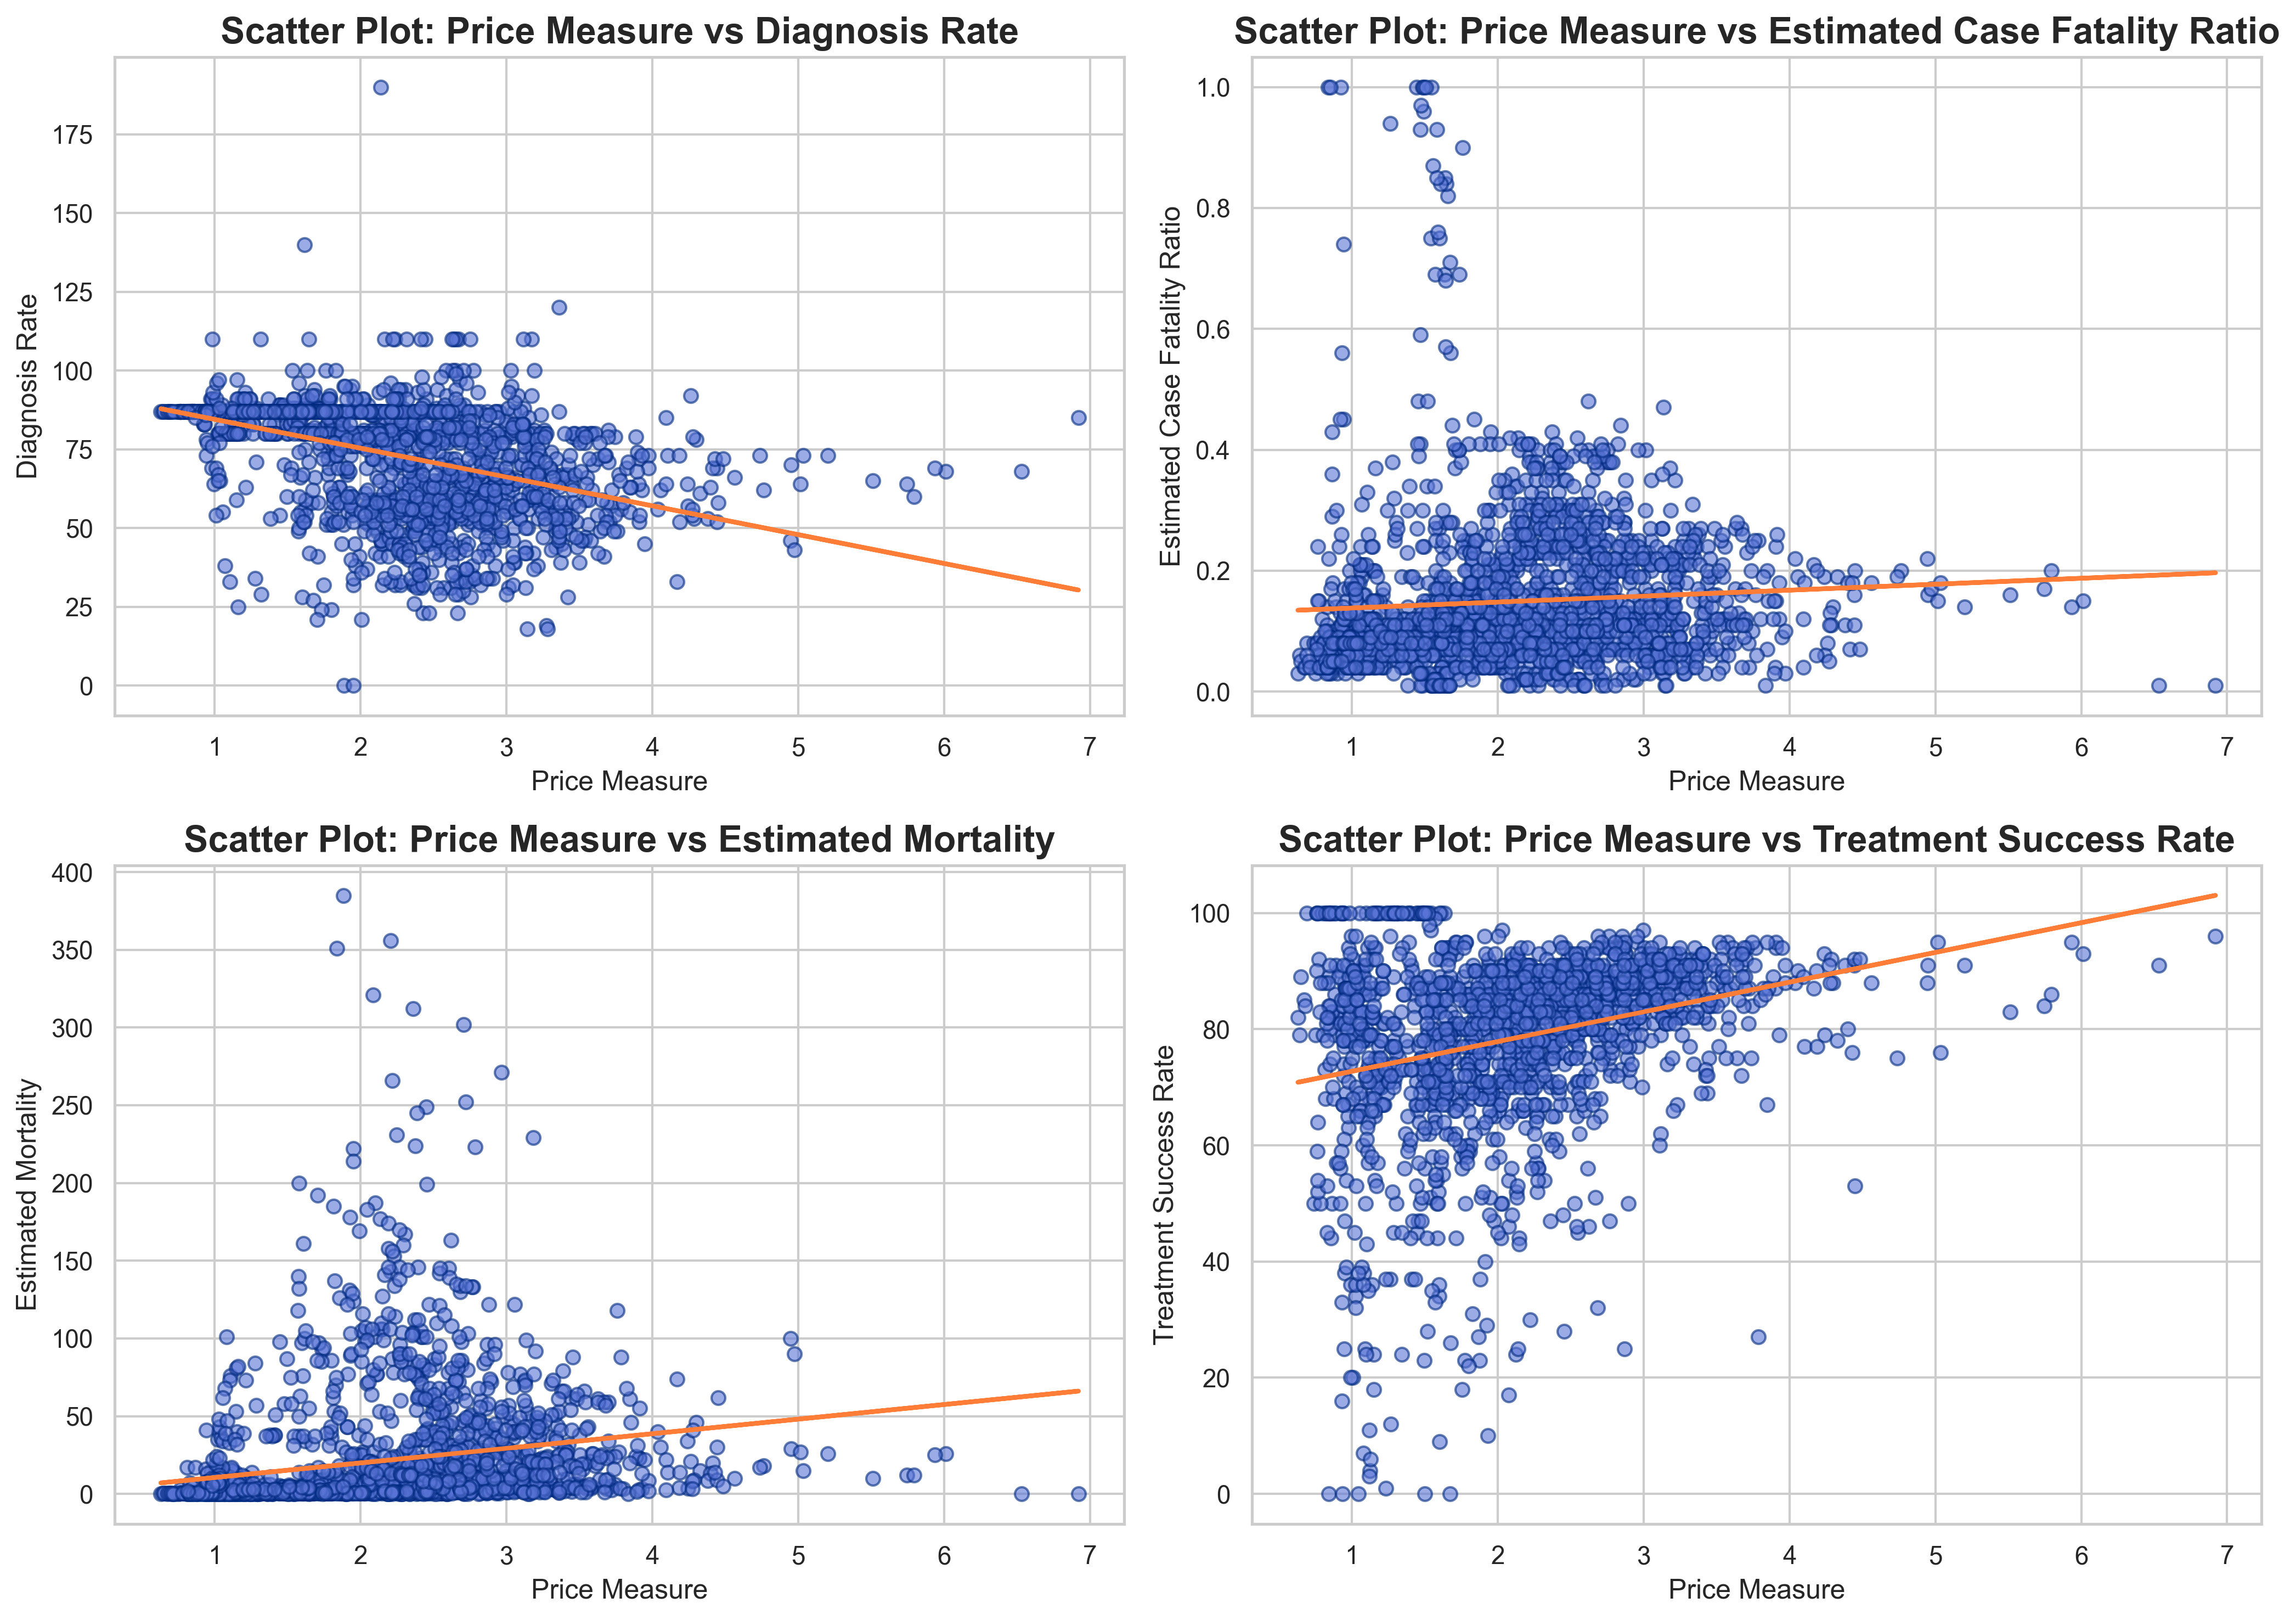

In [118]:
# list of variables to plot against 'Price Measure'
y_vars = ['c_cdr', 'cfr', 'e_mort_100k', 'c_new_tsr']
meanings = ['Diagnosis Rate', 'Estimated Case Fatality Ratio', 'Estimated Mortality', 'Treatment Success Rate']

# color palette
dot_color = '#5974d6'
line_color = '#ff7d36' #orange

# create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)

axes = axes.flatten()

# loop through the variables and create scatter plots with regression line
for i, y_var in enumerate(y_vars):
    # remove rows with NaN values for the current variable
    valid_data = price_regs[['Price Measure', y_var]].dropna()

    # Scatter plot with border color
    axes[i].scatter(valid_data['Price Measure'], valid_data[y_var], color=dot_color, alpha=0.6, edgecolors='#002a80')
        
    # fit linear regression
    # (degree 1 is linear)
    slope, intercept = np.polyfit(valid_data['Price Measure'], valid_data[y_var], 1)
    regression_line = slope * valid_data['Price Measure'] + intercept
    # plot regression line
    axes[i].plot(valid_data['Price Measure'], regression_line, color=line_color, linewidth=2, label='Regression Line')
    
    axes[i].set_title(f'Scatter Plot: Price Measure vs {meanings[i]}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel('Price Measure')
    axes[i].set_ylabel(meanings[i])

plt.tight_layout()
plt.show()


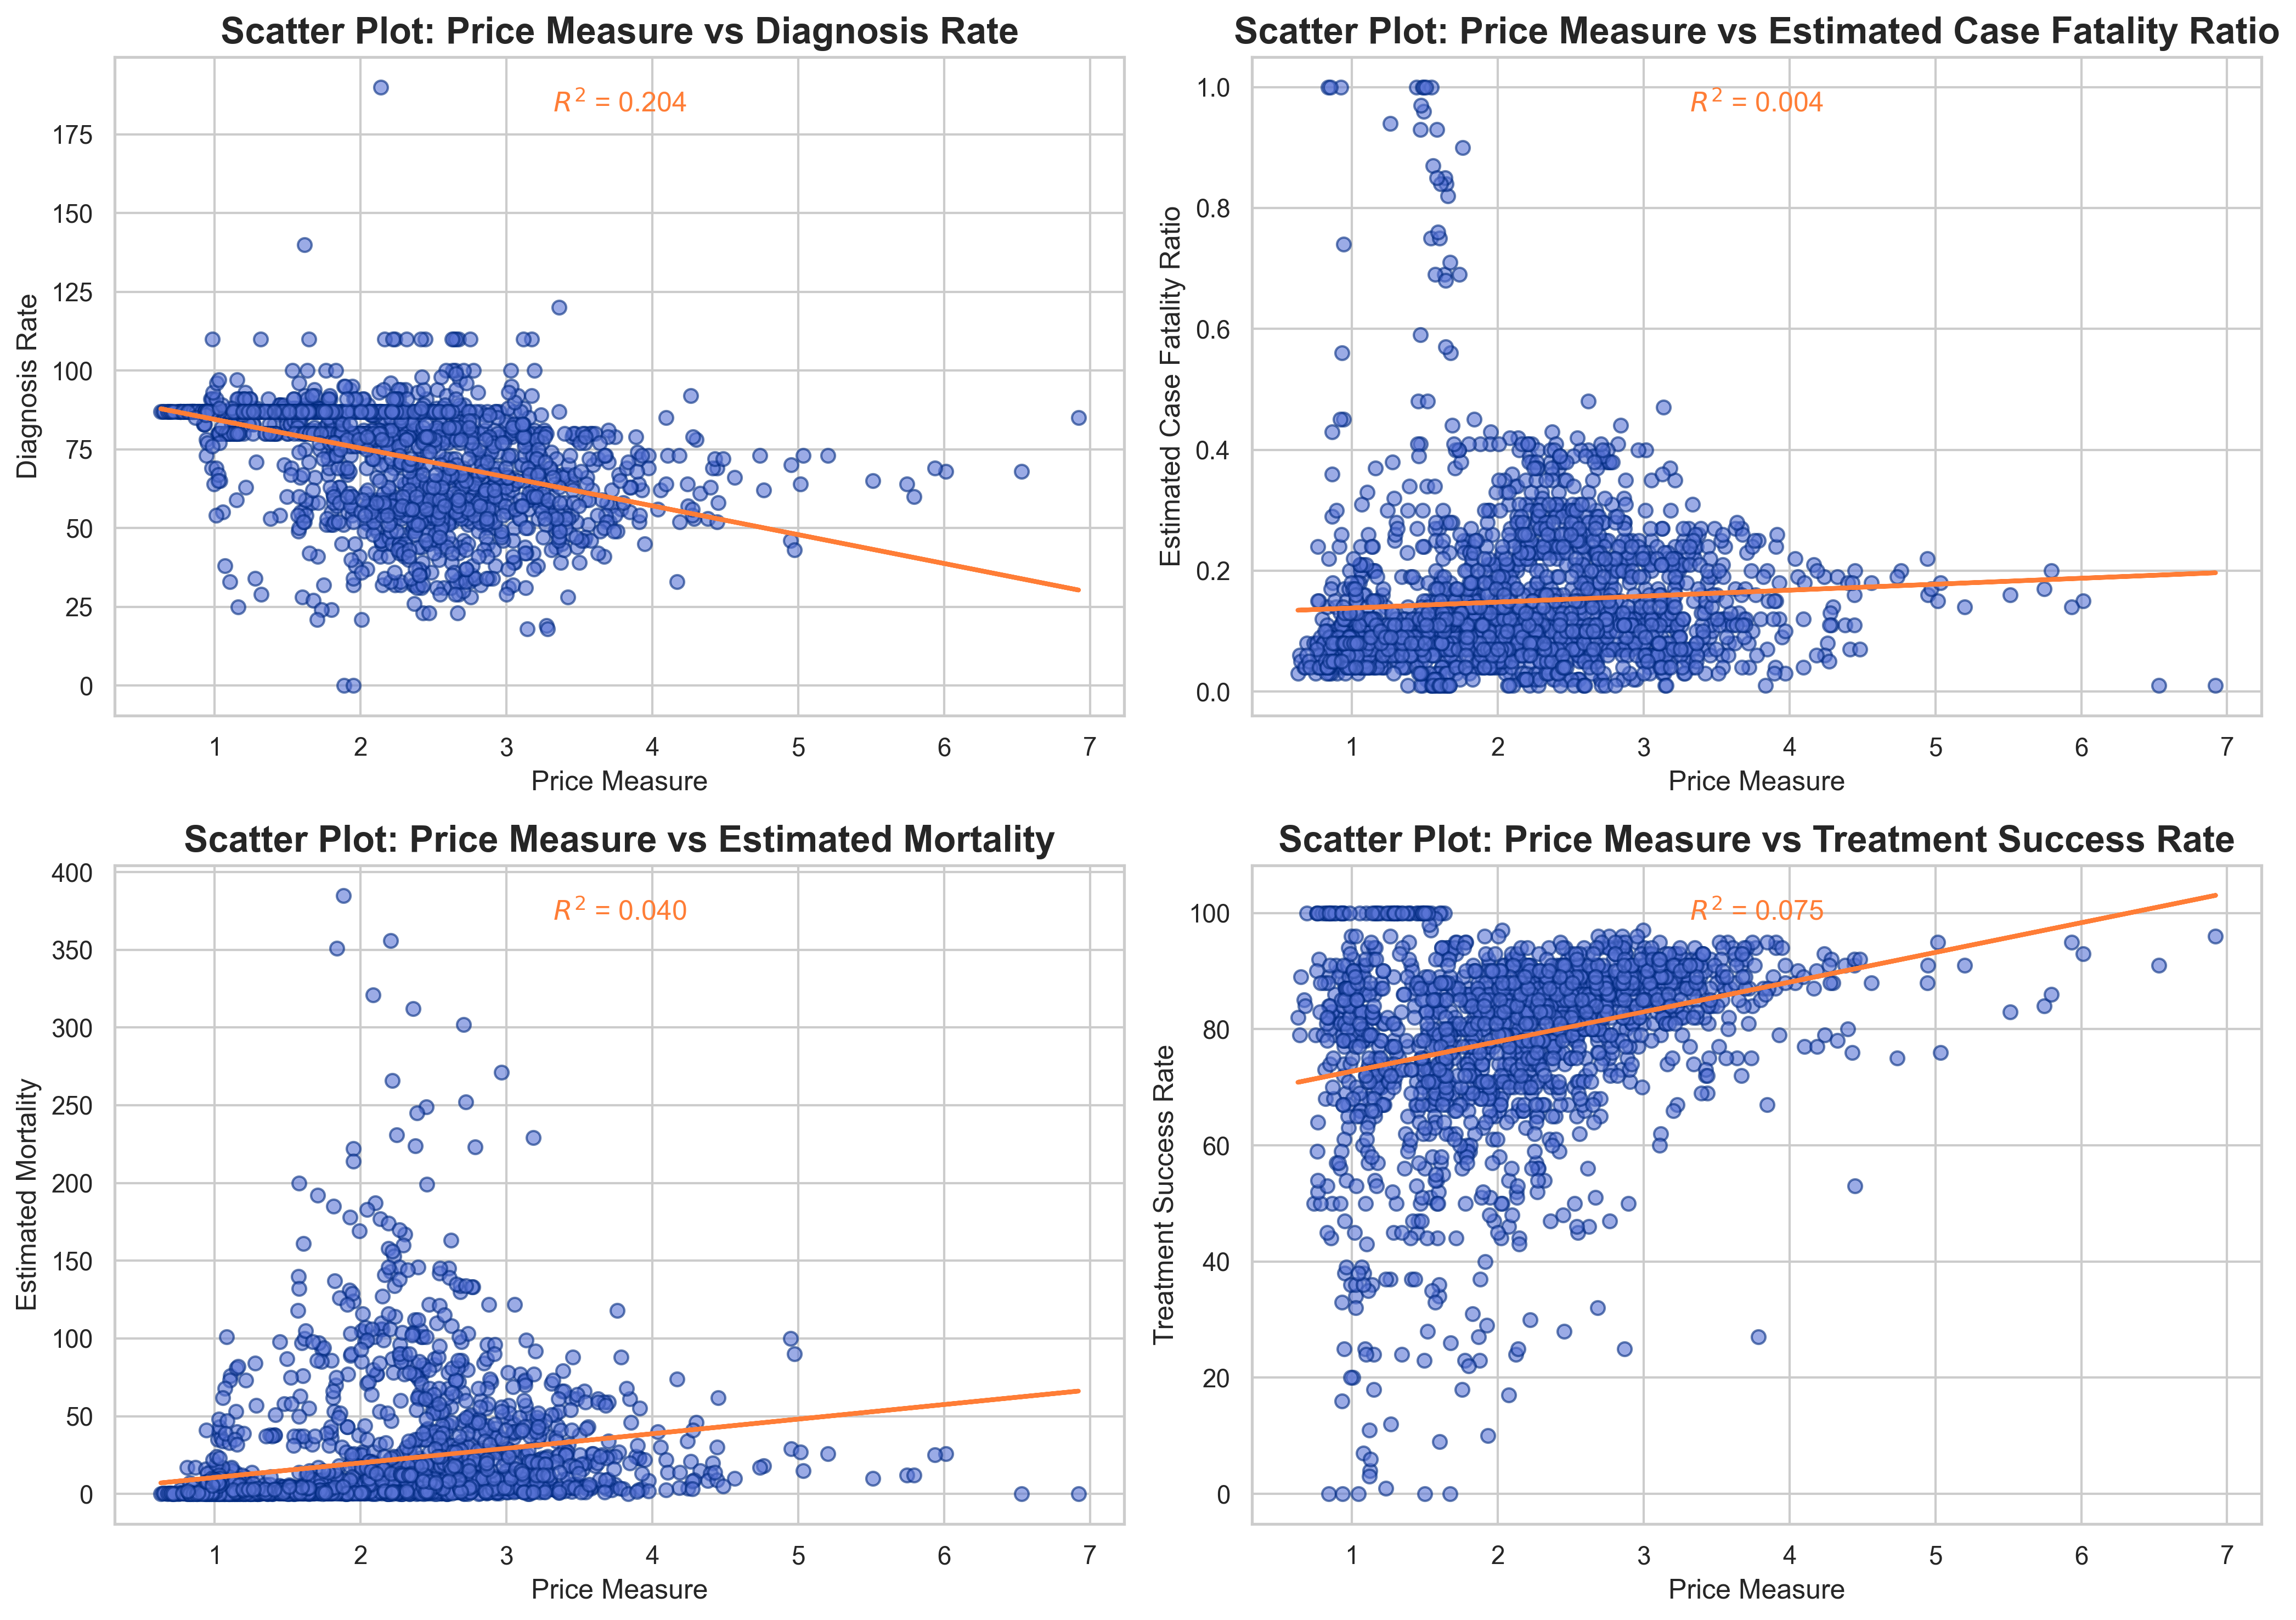

In [ ]:
# create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)
axes = axes.flatten()

# loop through the variables and create scatter plots with regression line
for i, y_var in enumerate(y_vars):
    # remove rows with NaN values for the current variable
    valid_data = price_regs[['Price Measure', y_var]].dropna()

    # Prepare X and y for the regression
    X = valid_data[['Price Measure']].values  # Must be 2D for sklearn
    y = valid_data[y_var].values

    # Fit linear regression using sklearn
    model = LinearRegression().fit(X, y)
    regression_line = model.predict(X)  # Generate the regression line
    r_squared = model.score(X, y)  # R² value

    # Scatter plot with border color
    axes[i].scatter(X, y, color=dot_color, alpha=0.6, edgecolors='#002a80', label='Data Points')

    # Plot the regression line
    axes[i].plot(X, regression_line, color=line_color, linewidth=2, label='Regression Line')

    # Add R² annotation in orange
    axes[i].annotate(f'$R^2$ = {r_squared:.3f}',
                     xy=(0.5, 0.95), xycoords='axes fraction',
                     fontsize=12, color=line_color,
                     ha='center', va='top')

    # Titles and labels
    axes[i].set_title(f'Scatter Plot: Price Measure vs {meanings[i]}',
                      fontsize=16, fontweight='bold')
    axes[i].set_xlabel('Price Measure', fontsize=12)
    axes[i].set_ylabel(meanings[i], fontsize=12)

# Layout adjustment
plt.tight_layout()
plt.show()


Analyse Regressions:

In [121]:
regression_results = {}

# loop through each dependent variable and run regression
for y_var in y_vars:
    y = price_regs[y_var]
    
    # drop rows with NaN values
    valid_data = price_regs[['Price Measure', y_var]].dropna()
    
    # define X and add constant for the intercept
    X = sm.add_constant(valid_data['Price Measure'])
    y = valid_data[y_var]
    
    # run OLS regression
    model = sm.OLS(y, X)
    results = model.fit() 
    
    regression_results[y_var] = results.summary()

for y_var, result in regression_results.items():
    print(f"Regression results for {y_var}:\n")
    print(result)
    print("\n" + "="*80 + "\n")

Regression results for c_cdr:

                            OLS Regression Results                            
Dep. Variable:                  c_cdr   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     510.2
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          9.32e-101
Time:                        19:03:03   Log-Likelihood:                -8250.4
No. Observations:                1991   AIC:                         1.650e+04
Df Residuals:                    1989   BIC:                         1.652e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          